# Import libraries

In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import datetime
import os
import numpy as np
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
# import shap

In [2]:
warnings.filterwarnings("ignore")

# Data Import

In [3]:
# Get the current working directory
current_dir = os.getcwd()
# Move up one level from the current directory
parent_dir = os.path.dirname(current_dir)
df = pd.read_csv(os.path.join(parent_dir, 'dataset', 'clean_data.csv'))

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
new_column_names = {'Dates Review': 'date_review',
                    'Day Review': 'day_review',
                    'Month Review': 'month_review',
                   'Month Review Number': 'month_review_num',
                   'Year Review': 'year_review',
                   'Verified': 'verified',
                   'Customer Name':'name',
                   'Month Flown': 'month_fly',
                   'Month Flown Number': 'month_fly_num',
                    'Year Flown':'year_fly',
                   'Month Year Flown': 'month_year_fly',
                   'Country': 'country',
                   'Aircraft': 'aircraft',
                   'Type Of Traveller': 'type',
                   'Seat Type': 'seat_type',
                   'Route': 'route',
                   'Seat Comfort': 'seat_comfort',
                   'Cabin Staff Service': 'cabit_serv',
                   'Food & Beverages': 'food',
                   'Ground Service': 'ground_service',
                   'Wifi & Connectivity': 'wifi',
                   'Value For Money': 'money_value',
                   'Recommended': 'recommended',
                   'Review': 'review'}

df.rename(columns=new_column_names, inplace=True)

In [6]:
df = df.drop(columns=['month_fly', 'month_fly_num','year_fly', 'day_review', 'month_review', 'month_review_num', 'year_review'])

In [7]:
df.columns

Index(['Unnamed: 0', 'id', 'date_review', 'verified', 'name', 'month_year_fly',
       'country', 'aircraft', 'type', 'seat_type', 'route', 'seat_comfort',
       'cabit_serv', 'food', 'ground_service', 'wifi', 'money_value',
       'recommended', 'review'],
      dtype='object')

In [8]:
df.dtypes

Unnamed: 0          int64
id                  int64
date_review        object
verified             bool
name               object
month_year_fly     object
country            object
aircraft           object
type               object
seat_type          object
route              object
seat_comfort      float64
cabit_serv        float64
food              float64
ground_service    float64
wifi              float64
money_value         int64
recommended        object
review             object
dtype: object

In [9]:
df['recommended'] = df['recommended'].replace({'yes': 1, 'no': 0})
df['verified'] = df['verified'].astype('str')
df['verified'] = df['verified'].replace({'True': 1, 'False': 0})

In [10]:
df['aircraft'].fillna(0, inplace=True)
df['wifi'].fillna(0, inplace=True)
df['aircraft'] = df['aircraft'].apply(lambda x: 1 if x != 0 else 0)
df['wifi'] = df['wifi'].apply(lambda x: 1 if x != 0 else 0)

In [11]:
#df['date_review'] = df['date_review'].astype('datetime64[ns]')
#df['month_year_fly'] = df['month_year_fly'].astype('datetime64[ns]')
df['seat_comfort'] = pd.to_numeric(df['seat_comfort'], errors='coerce').astype('Int64')
df['cabit_serv'] = pd.to_numeric(df['cabit_serv'], errors='coerce').astype('Int64')
df['food'] = pd.to_numeric(df['food'], errors='coerce').astype('Int64')
df['ground_service'] = pd.to_numeric(df['ground_service'], errors='coerce').astype('Int64')

In [12]:
df.head(3)

,Unnamed: 0,id,date_review,verified,name,month_year_fly,country,aircraft,type,seat_type,route,seat_comfort,cabit_serv,food,ground_service,wifi,money_value,recommended,review
0,0,0,2024-03-05,1,I Carsen,03-2024,Australia,1,Business,Business Class,Singapore to Sydney,1,1,2,3,0,2,0,The worst business class experience. Ground cr...
1,3,1,2024-03-04,1,E Gayerlo,03-2024,United Kingdom,1,Couple Leisure,Business Class,London Heathrow to Mexico City,2,2,1,2,1,1,0,"On the my trip to Mexico City, I had the oppor..."
2,1,2,2024-03-04,0,L Kelly,02-2024,Canada,0,Business,Business Class,Cyprus to London,1,3,<NA>,3,1,1,0,Quite possibly the worst business class I have...


# Null Handling

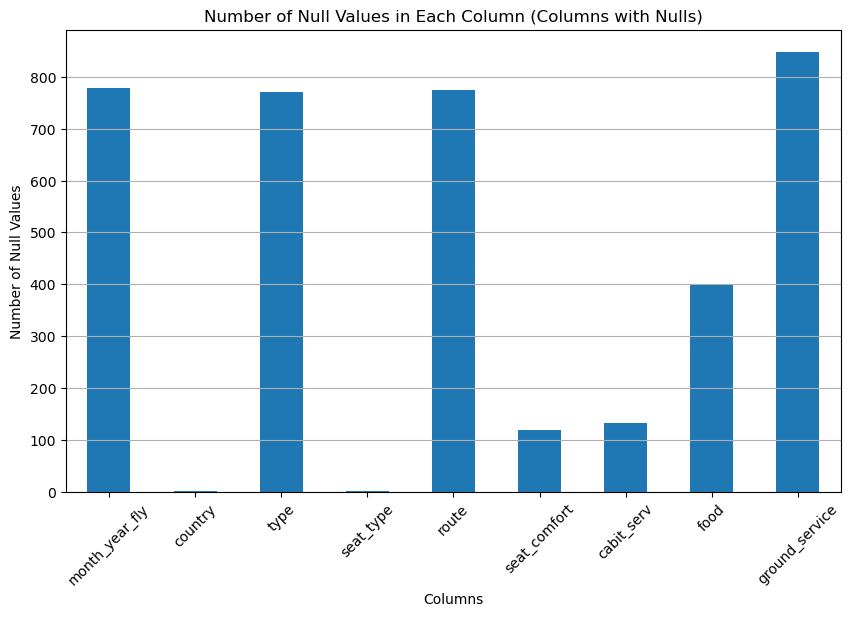

In [13]:
null_counts = df.isnull().sum()

null_counts_filtered = null_counts[null_counts > 0]

null_counts_filtered.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Null Values in Each Column (Columns with Nulls)')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45)  
plt.grid(axis='y')  
plt.show()

In [14]:
df.seat_comfort

0          1
1          2
2          1
3          2
4          4
        ... 
3757       4
3758       4
3759    <NA>
3760       1
3761       4
Name: seat_comfort, Length: 3762, dtype: Int64

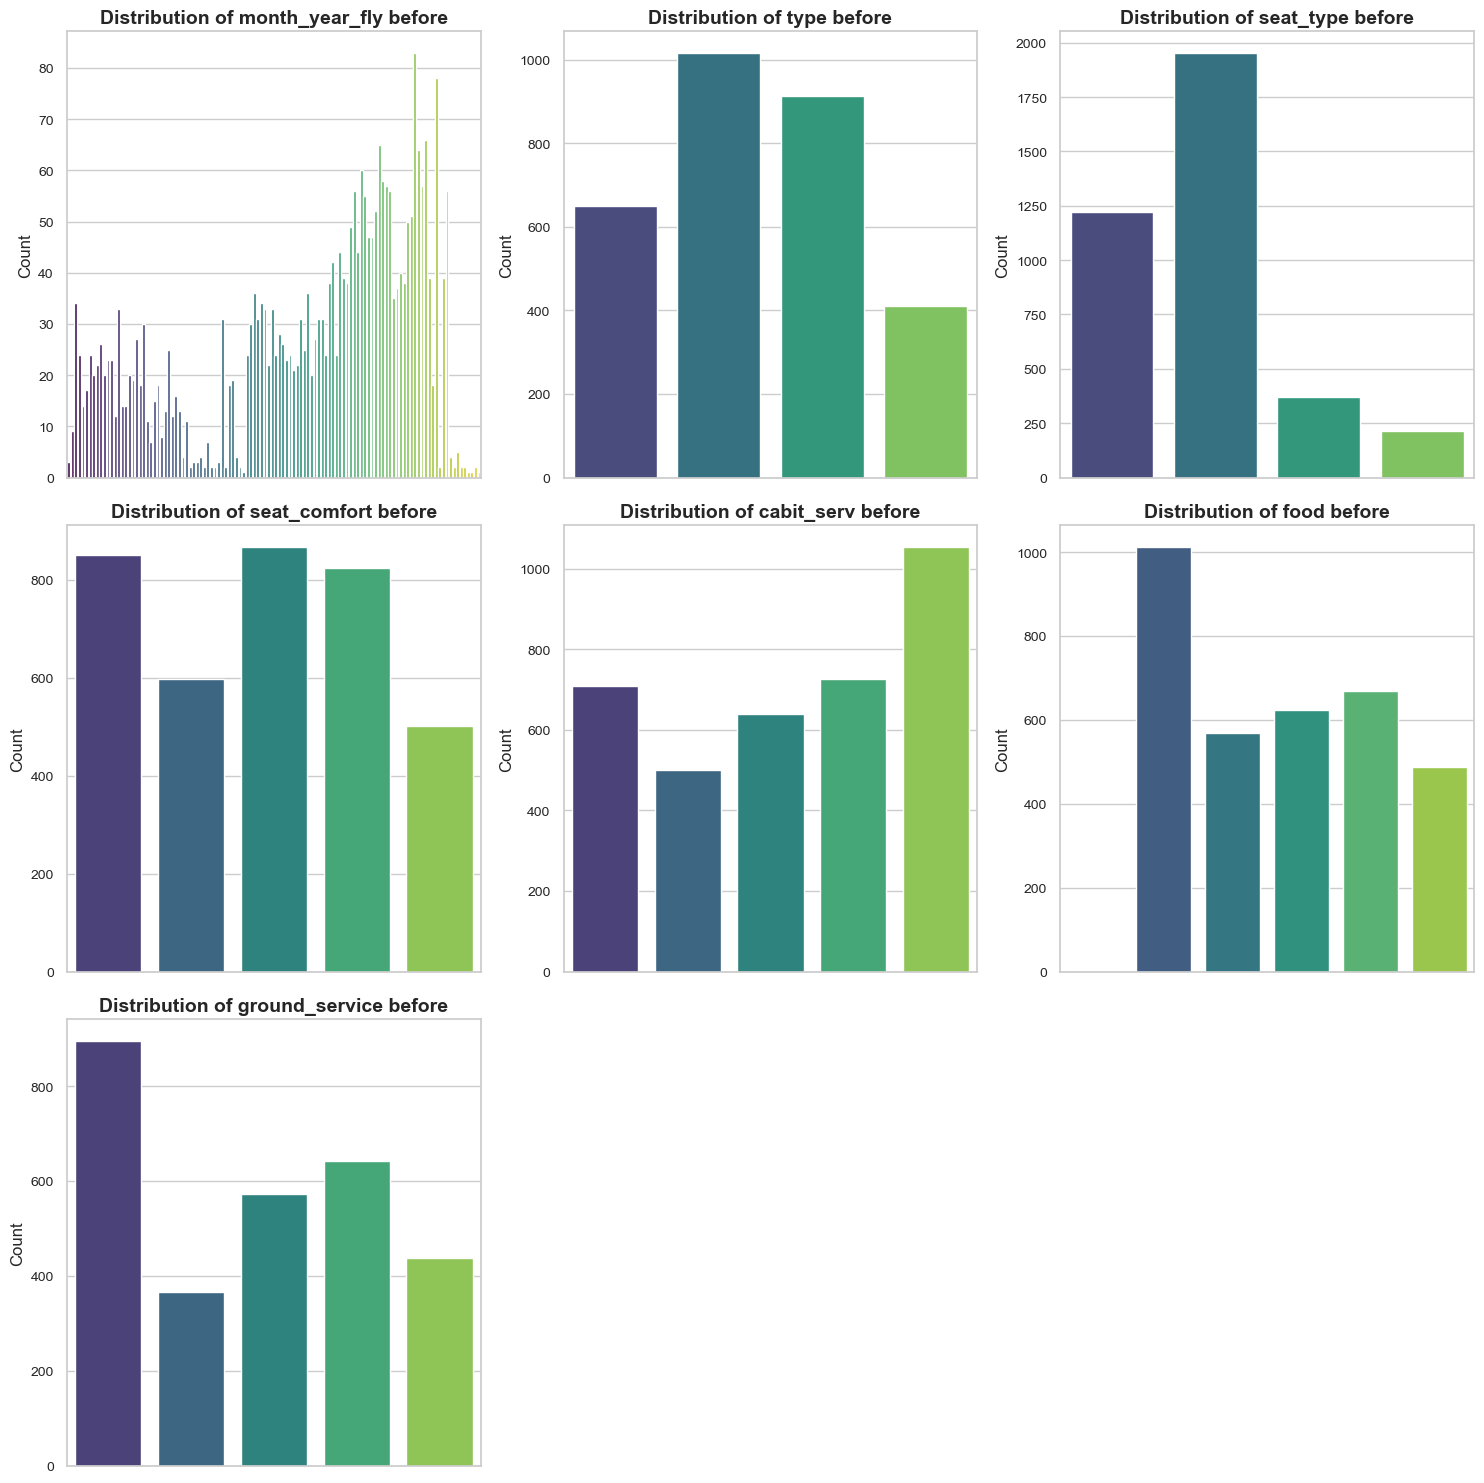

In [15]:
# Assuming df is your DataFrame containing the data

categorical_columns = ['month_year_fly', 'type', 'seat_type', 'seat_comfort',
                        'cabit_serv', 'food', 'ground_service']
num_columns = 3
num_rows = (len(categorical_columns) - 1) // num_columns + 1

plt.figure(figsize=(15, num_rows * 5))
sns.set(style="whitegrid")

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    
    # Handle NaN values in the current column
    column_values = df[column].dropna()
    
    # Plot count distribution
    sns.countplot(x=column_values, palette="viridis")
    
    plt.title(f'Distribution of {column} before', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

plt.show()

In [16]:
# Handling 'seat_comfort', 'cabit_serv', 'food', 'ground_service'
columns_with_missing = ['seat_comfort', 'cabit_serv', 'food', 'ground_service']
imputer = KNNImputer(n_neighbors=5)
df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

In [17]:
review_columns = ['seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']
df[review_columns] = df[review_columns].round()

In [18]:
# Handling 'country' and 'seat_type' NAs
df['country'].fillna(df['country'].mode()[0], inplace = True)
df['seat_type'].fillna(df['seat_type'].mode()[0], inplace = True)

In [19]:
# Handling 'type' NAs
df_known_type = df[df['type'].notna()]
df_missing_type = df[df['type'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_type[features], df_known_type['type'])

predicted_type = rf_classifier.predict(df_missing_type[features])
df.loc[df['type'].isna(), 'type'] = predicted_type

In [20]:
# Handling 'route' NAs
df_known_route = df[df['route'].notna()]
df_missing_route = df[df['route'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_route[features], df_known_route['route'])

predicted_route = rf_classifier.predict(df_missing_route[features])
df.loc[df['route'].isna(), 'route'] = predicted_route

In [21]:
# Handling 'month_year_fly' NAs
df_known_time = df[df['month_year_fly'].notna()]
df_missing_time = df[df['month_year_fly'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_time[features], df_known_time['month_year_fly'])

predicted_time = rf_classifier.predict(df_missing_time[features])
df.loc[df['month_year_fly'].isna(), 'month_year_fly'] = predicted_time

In [22]:
def clean_route(df):
    """
    Clean the 'route' column of the DataFrame and split it into 'origin', 'destination', and 'transit' columns.

    Parameters:
    df (DataFrame): DataFrame containing a 'route' column.

    Returns:
    DataFrame: DataFrame with 'origin', 'destination', and 'transit' columns.
    """
    df = df.dropna(subset=['route'])
    # Function to split the route into origin, destination, and transit
    def split_route(route):
        parts = route.split(' to ')
        origin = parts[0]
        if len(parts) > 1:
            destination, transit = parts[1].split(' via ') if ' via ' in parts[1] else (parts[1], None)
        else:
            destination, transit = None, None
        return origin, destination, transit

    # Apply the function to create new columns
    df[['origin', 'destination', 'transit']] = df['route'].apply(split_route).apply(pd.Series)

    return df

In [23]:
df = clean_route(df)

In [24]:
df.head(4)

,Unnamed: 0,id,date_review,verified,name,month_year_fly,country,aircraft,type,seat_type,route,seat_comfort,cabit_serv,food,ground_service,wifi,money_value,recommended,review,origin,destination,transit
0,0,0,2024-03-05,1,I Carsen,03-2024,Australia,1,Business,Business Class,Singapore to Sydney,1.0,1.0,2.0,3.0,0,2,0,The worst business class experience. Ground cr...,Singapore,Sydney,None
1,3,1,2024-03-04,1,E Gayerlo,03-2024,United Kingdom,1,Couple Leisure,Business Class,London Heathrow to Mexico City,2.0,2.0,1.0,2.0,1,1,0,"On the my trip to Mexico City, I had the oppor...",London Heathrow,Mexico City,None
2,1,2,2024-03-04,0,L Kelly,02-2024,Canada,0,Business,Business Class,Cyprus to London,1.0,3.0,2.0,3.0,1,1,0,Quite possibly the worst business class I have...,Cyprus,London,None
3,2,3,2024-03-04,0,Jana Chua,03-2024,Singapore,0,Solo Leisure,Economy Class,Singapore to Auckland via Sydney,2.0,3.0,3.0,1.0,1,1,0,I will never be flying with BA again. This is ...,Singapore,Auckland,Sydney


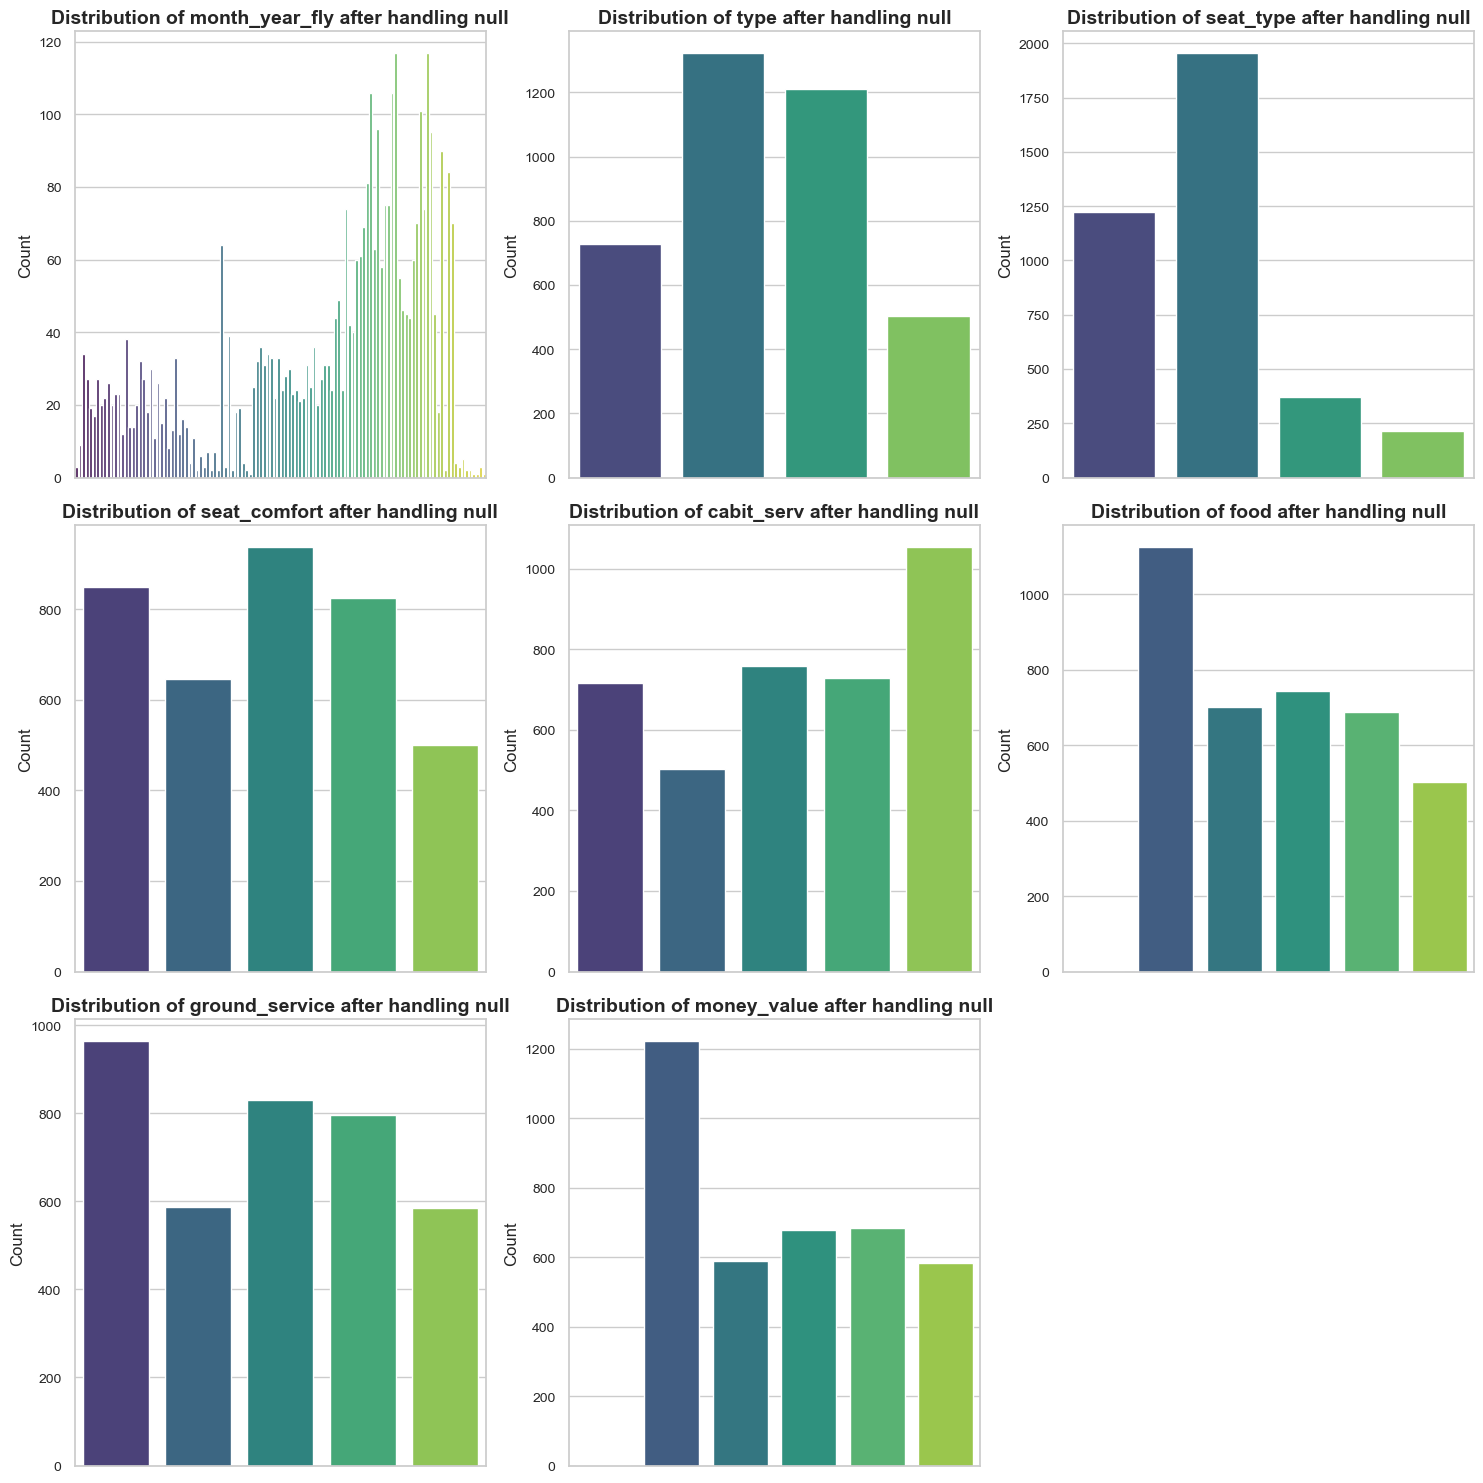

In [25]:
categorical_columns = ['month_year_fly', 'type', 'seat_type', 
                       'seat_comfort', 'cabit_serv', 'food', 'ground_service', 'money_value']
num_columns = 3
num_rows = (len(categorical_columns) - 1) // num_columns + 1

plt.figure(figsize=(15, num_rows * 5))
sns.set(style="whitegrid")

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.countplot(data=df, x=column, palette="viridis")
    plt.title(f'Distribution of {column} after handling null', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3762 non-null   int64  
 1   id              3762 non-null   int64  
 2   date_review     3762 non-null   object 
 3   verified        3762 non-null   int64  
 4   name            3762 non-null   object 
 5   month_year_fly  3762 non-null   object 
 6   country         3762 non-null   object 
 7   aircraft        3762 non-null   int64  
 8   type            3762 non-null   object 
 9   seat_type       3762 non-null   object 
 10  route           3762 non-null   object 
 11  seat_comfort    3762 non-null   float64
 12  cabit_serv      3762 non-null   float64
 13  food            3762 non-null   float64
 14  ground_service  3762 non-null   float64
 15  wifi            3762 non-null   int64  
 16  money_value     3762 non-null   int64  
 17  recommended     3762 non-null   i

# Feature Engineering

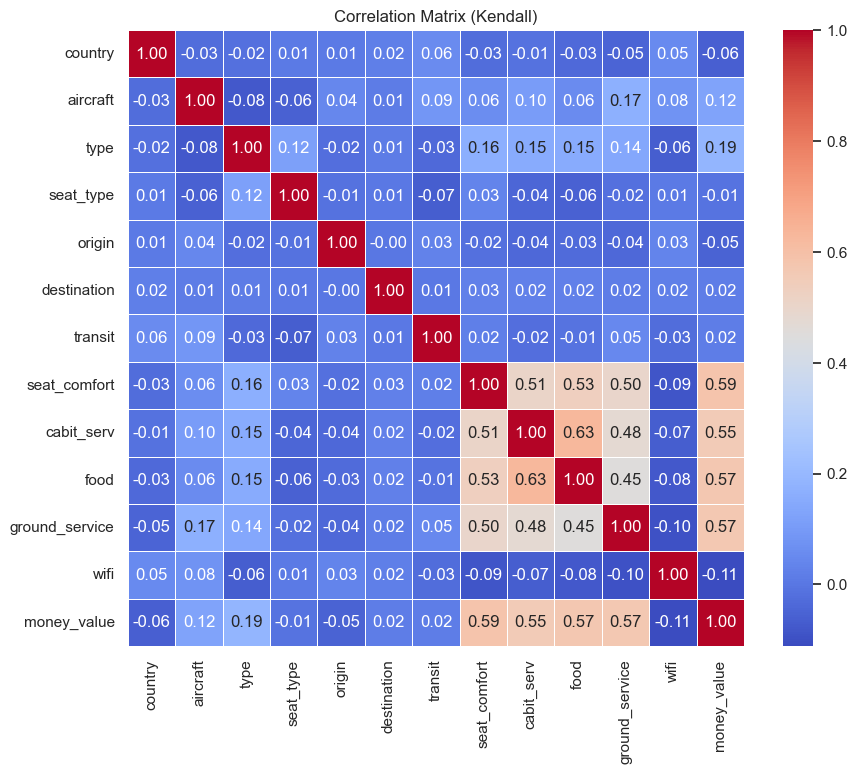

In [27]:
explanatory_vars = ['country', 'aircraft', 'type', 'seat_type', 'origin', 'destination', 'transit' , 'seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']

label_encoder = LabelEncoder()
for var in explanatory_vars:
    df[var] = label_encoder.fit_transform(df[var])

correlation_matrix = df[explanatory_vars + ['money_value']].corr(method='kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix (Kendall)')
plt.show()

In [28]:
# Filter correlation pairs for money_value and sort
money_value_correlations = correlation_matrix['money_value'].sort_values(ascending=False)
money_value_correlations = money_value_correlations[money_value_correlations.index != 'money_value']
print(money_value_correlations)

seat_comfort      0.585911
food              0.573058
ground_service    0.568208
cabit_serv        0.554962
type              0.186622
aircraft          0.124989
destination       0.017796
transit           0.017056
seat_type        -0.010279
origin           -0.054022
country          -0.062158
wifi             -0.111145
Name: money_value, dtype: float64


In [29]:
def calculate_tree_importance(X, y):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    tree_importance = rf_model.feature_importances_
    tree_sorted_idx = np.argsort(tree_importance)[::-1]
    sorted_feature_names = X.columns[tree_sorted_idx]
    sorted_importances = tree_importance[tree_sorted_idx]
    
    plt.figure(figsize=(11.7, 8.27))
    sns.barplot(x=sorted_importances, y=sorted_feature_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Tree-based Feature Importance')
    plt.show()
    
    return tree_sorted_idx

In [30]:
def calculate_permutation_importance(X, y):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    perm_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)
    perm_sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]
    
    plt.figure(figsize=(11.7, 8.27))
    sns.barplot(x=perm_importance.importances_mean[perm_sorted_idx], y=X.columns[perm_sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Permutation-based Feature Importance')
    plt.show()
    
    return perm_sorted_idx

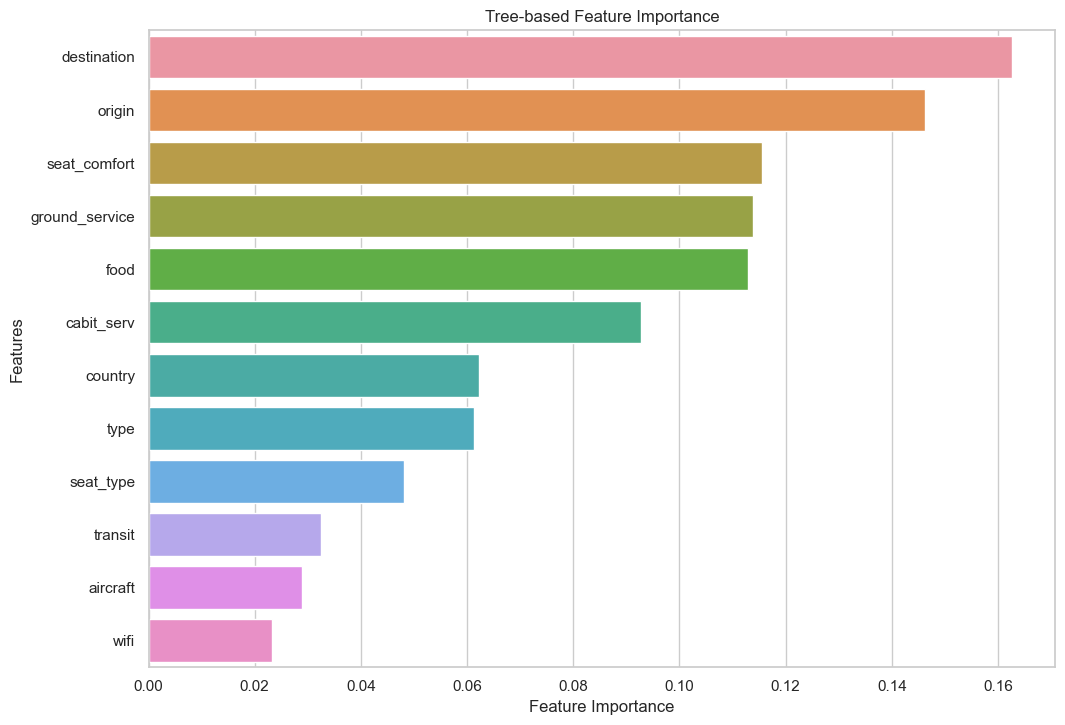

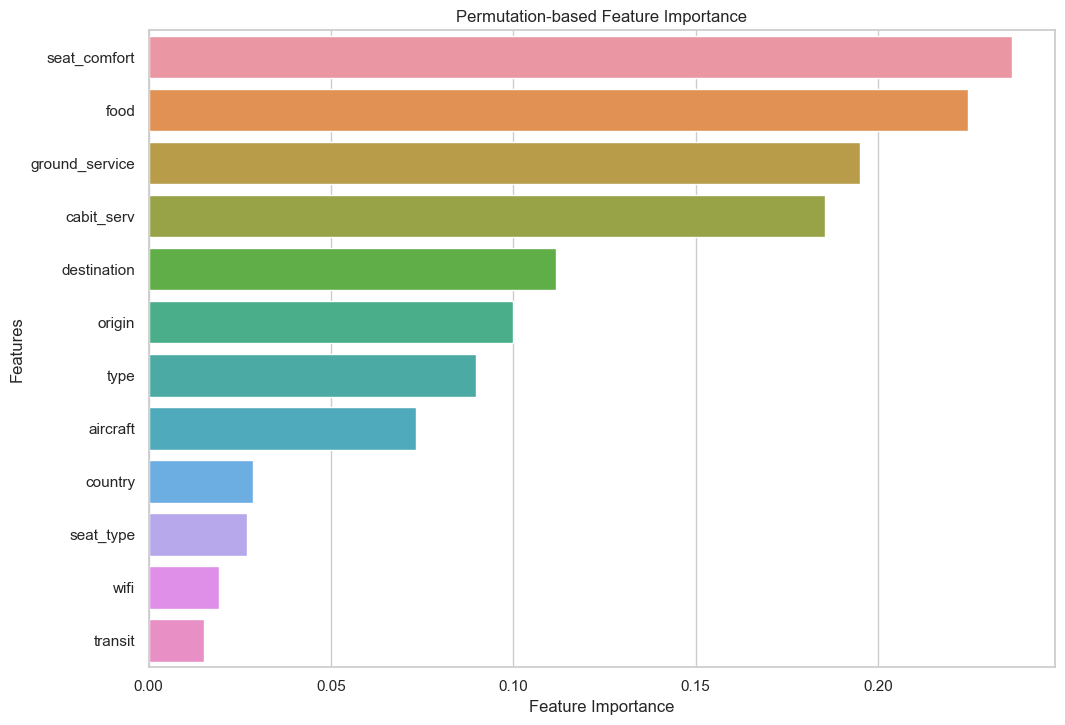

Top 3 significant features based on tree-based importance: Index(['destination', 'origin', 'seat_comfort'], dtype='object')
Top 3 significant features based on permutation importance: Index(['seat_comfort', 'food', 'ground_service'], dtype='object')


In [31]:
# General case
X = df[explanatory_vars]
y = df['money_value']

tree_sorted_idx = calculate_tree_importance(X, y)
perm_sorted_idx = calculate_permutation_importance(X, y)

top_perm_features = X.columns[perm_sorted_idx[:3]]
top_tree_features = X.columns[tree_sorted_idx[:3]]


print("Top 3 significant features based on tree-based importance:", top_tree_features)
print("Top 3 significant features based on permutation importance:", top_perm_features)

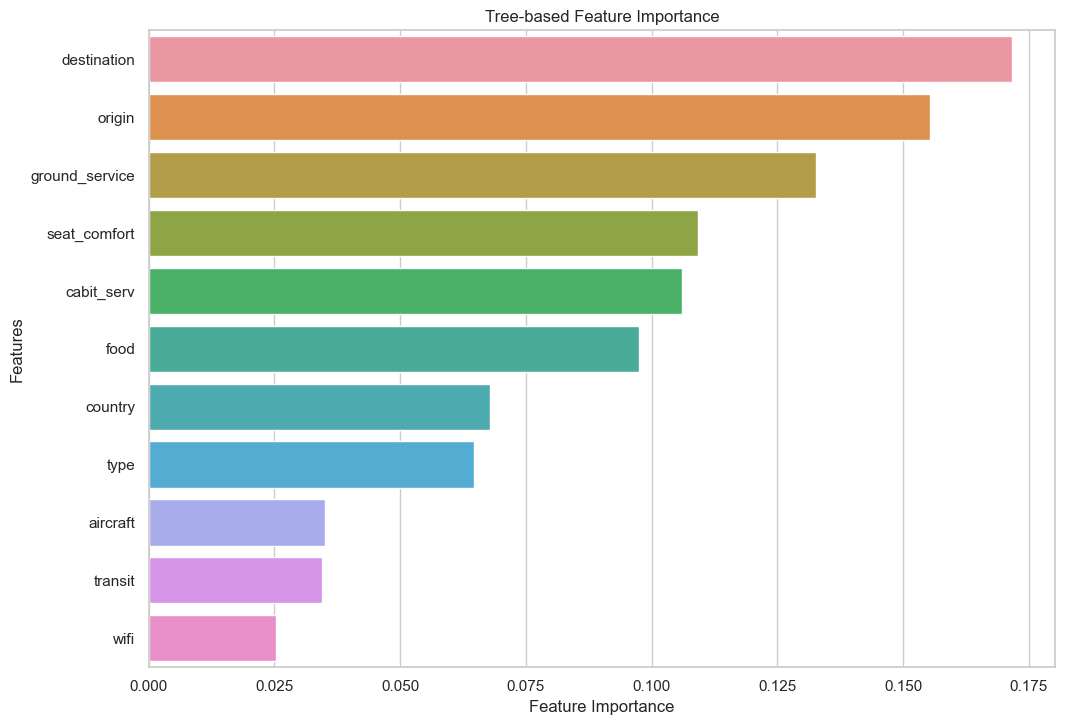

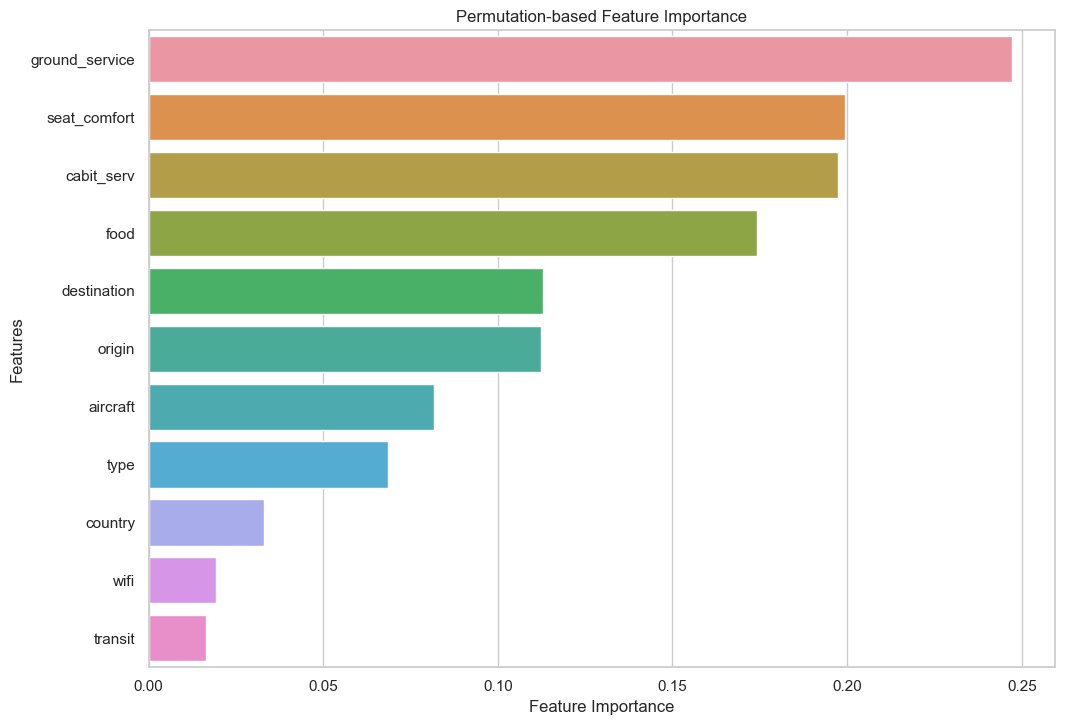

Top 3 significant features based on tree-based importance for Economy seat type: Index(['destination', 'origin', 'ground_service'], dtype='object')
Top 3 significant features based on permutation importance for Economy seat type: Index(['ground_service', 'seat_comfort', 'cabit_serv'], dtype='object')


In [32]:
# Economy case
economy_class_df = df[df['seat_type'] == 1]
explanatory_vars = ['country', 'aircraft', 'type','origin', 'destination', 'transit' , 'seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']

X_economy = economy_class_df[explanatory_vars]
y_economy = economy_class_df['money_value']

tree_sorted_idx_economy = calculate_tree_importance(X_economy, y_economy)
top_tree_features_economy = X_economy.columns[tree_sorted_idx_economy[:3]]
perm_sorted_idx_economy = calculate_permutation_importance(X_economy, y_economy)
top_perm_features_economy = X_economy.columns[perm_sorted_idx_economy[:3]]


print("Top 3 significant features based on tree-based importance for Economy seat type:", top_tree_features_economy)
print("Top 3 significant features based on permutation importance for Economy seat type:", top_perm_features_economy)

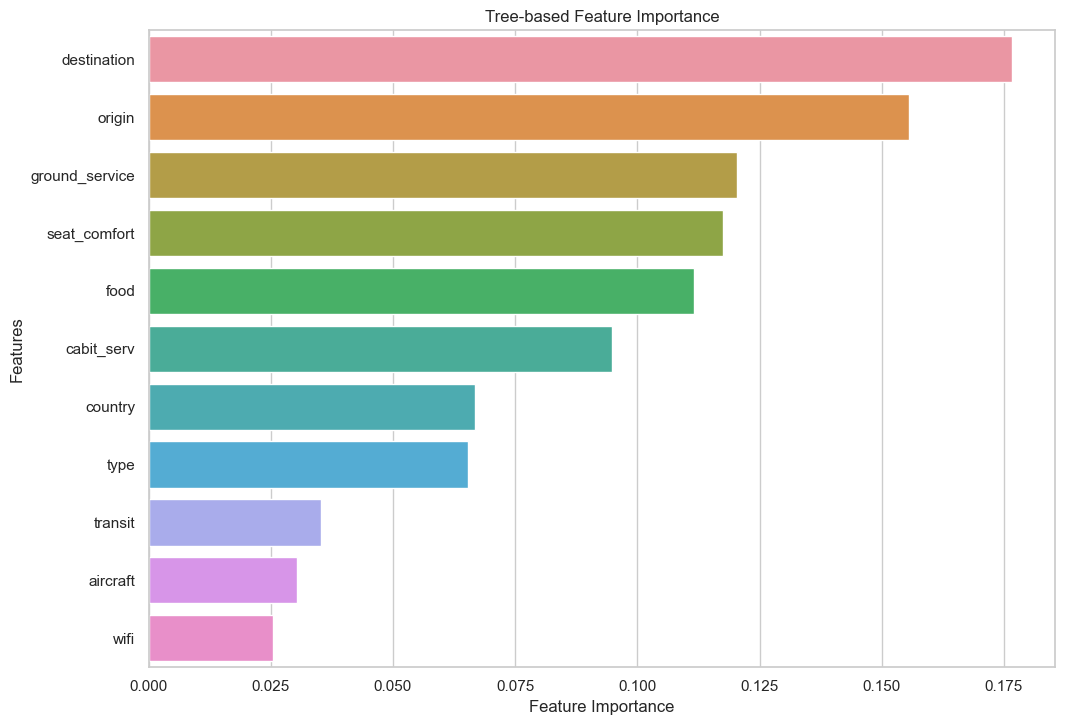

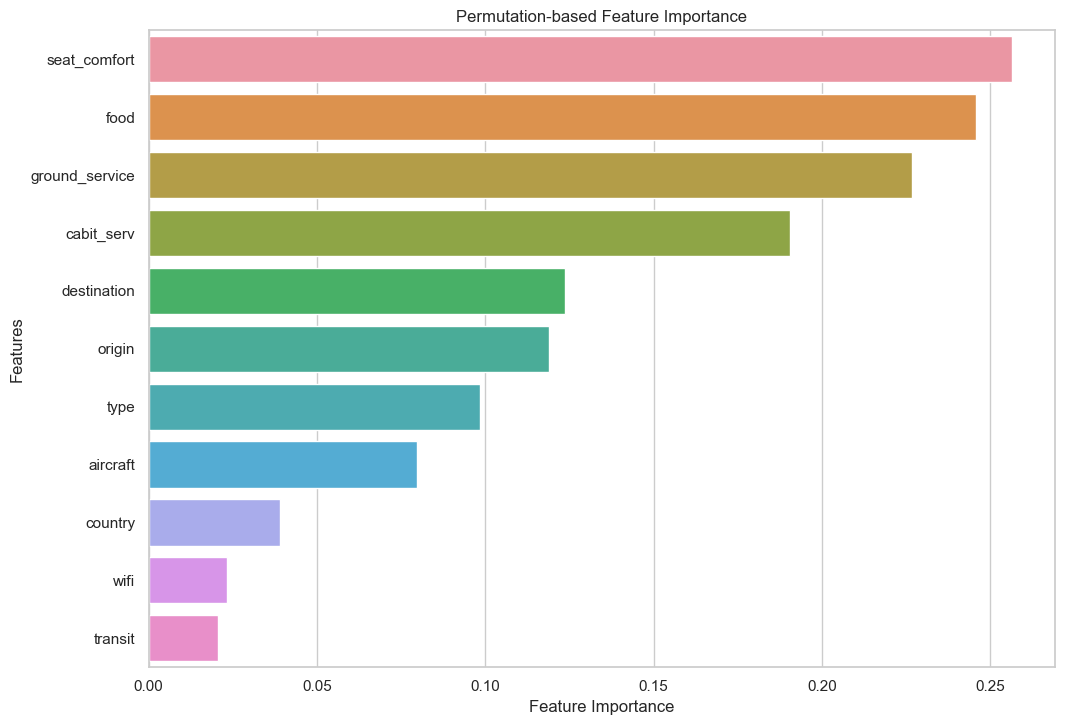

Top 3 significant features based on permutation importance for non-Economy seat type: Index(['seat_comfort', 'food', 'ground_service'], dtype='object')
Top 3 significant features based on tree-based importance for non-Economy seat type: Index(['destination', 'origin', 'ground_service'], dtype='object')


In [33]:
# Non-economy case
non_economy_class_df = df[df['seat_type'] != 'Economy']
explanatory_vars = ['country', 'aircraft', 'type','origin', 'destination', 'transit' , 'seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']

X_non_economy = non_economy_class_df[explanatory_vars]
y_non_economy = non_economy_class_df['money_value']

tree_sorted_idx_non_economy = calculate_tree_importance(X_non_economy, y_non_economy)
top_tree_features_non_economy = X_non_economy.columns[tree_sorted_idx_non_economy[:3]]
perm_sorted_idx_non_economy = calculate_permutation_importance(X_non_economy, y_non_economy)
top_perm_features_non_economy = X_non_economy.columns[perm_sorted_idx_non_economy[:3]]

print("Top 3 significant features based on permutation importance for non-Economy seat type:", top_perm_features_non_economy)
print("Top 3 significant features based on tree-based importance for non-Economy seat type:", top_tree_features_non_economy)